In [ ]:
## 기본 라이브러리 호출
import numpy as np
import pandas as pd

## Matplot 호출 및 plotting style 정의 
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['image.cmap'] = 'jet'

In [ ]:
## 구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4. Stationarize a time series

모델 예측을 하기 전, 시계열 데이터는 stationary 하게 변환되어야 함. Augmented-Dickey Fuller Test는 통계적으로 stationary를 확인하는 방법으로 귀무가설 (non-stationary)에 대한 p-value를 통해 귀무가설 reject or accept. 혹은 test statistic이 critical value보다 작을 때 귀무가설 reject.

Staionary하다면 더 이상의 변환은 필요 없음.

In [ ]:
## load passenger data set and safe to DataFrame
datapath = '/content/drive/MyDrive/시계열/실습/데이터/international-airline-passengers.csv'
df = pd.read_csv(datapath, header=None, index_col=0)
df = df.rename(columns={1: 'passengers'}) # column 명과
df = df.rename_axis('month') # 인덱스 명 바꿈
df.index = pd.to_datetime(df.index, format='%Y-%m') # 인덱스를 datetime format으로
y = df['passengers'] # New pandas Series

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_test(y):
    ## perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [ ]:
adf_test(y)

Results of Augmented Dickey-Fuller test:
test statistic            0.815369
p-value                   0.991880
# of lags                13.000000
# of observations       130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


Test statistic이 5% critical value보다 크고 p-value가 매우 높으므로 귀무가설이 기각되기가 어려움. 따라서 non stationary.


Stationary check를 위해 ACF, PACF, QQ plot, histrogram, ADT test를 확인하여 plot 하는 함수.


In [ ]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [ ]:
def ts_diagnostics(y, lags=None, title=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    ## Moving averages of window 12
    rolling_mean = y.rolling(window=12).mean()
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    ## Time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson')
    plt.legend(loc='best')
    ts_ax.set_title(title, fontsize=24)
    
    ## Acf and Pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plt.tight_layout()
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return 

No handles with labels found to put in legend.


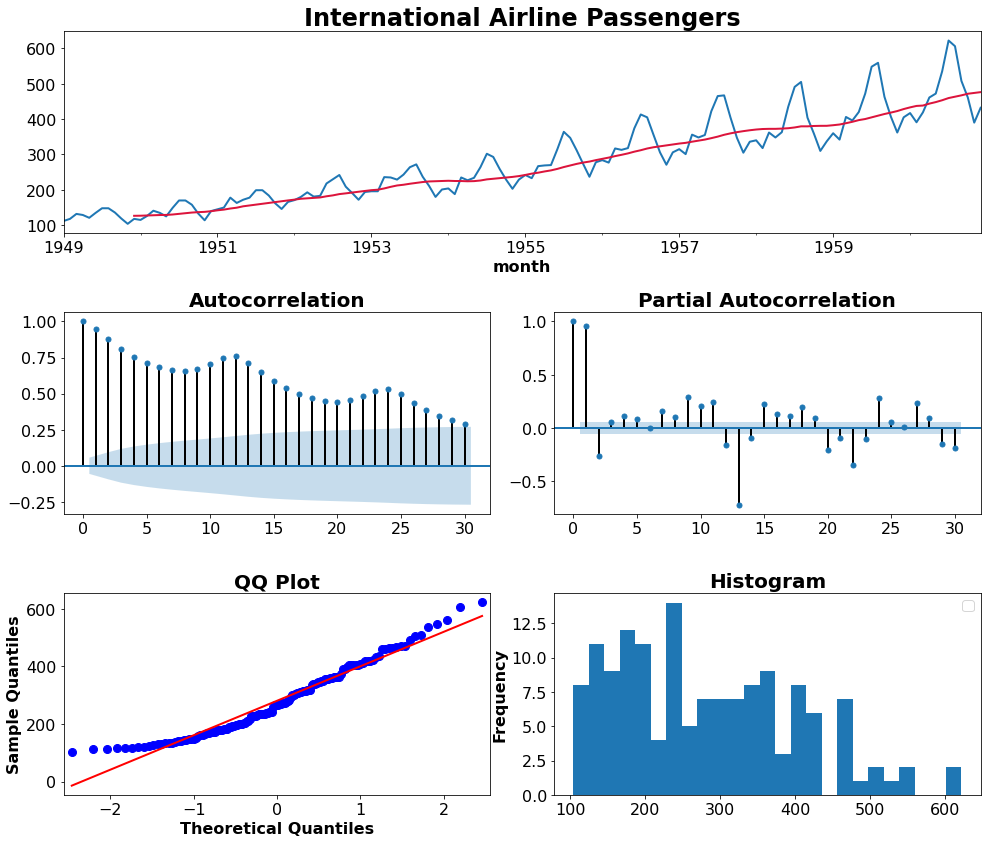

Results of Dickey-Fuller test:
test statistic            0.815369
p-value                   0.991880
# of lags                13.000000
# of observations       130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [ ]:
ts_diagnostics(y, lags=30, title='International Airline Passengers')

## 4.1 Trend stationary

1차 미분을 통해 선형 추세를 제거

In [ ]:
y_diff = np.diff(y, n=1)

No handles with labels found to put in legend.


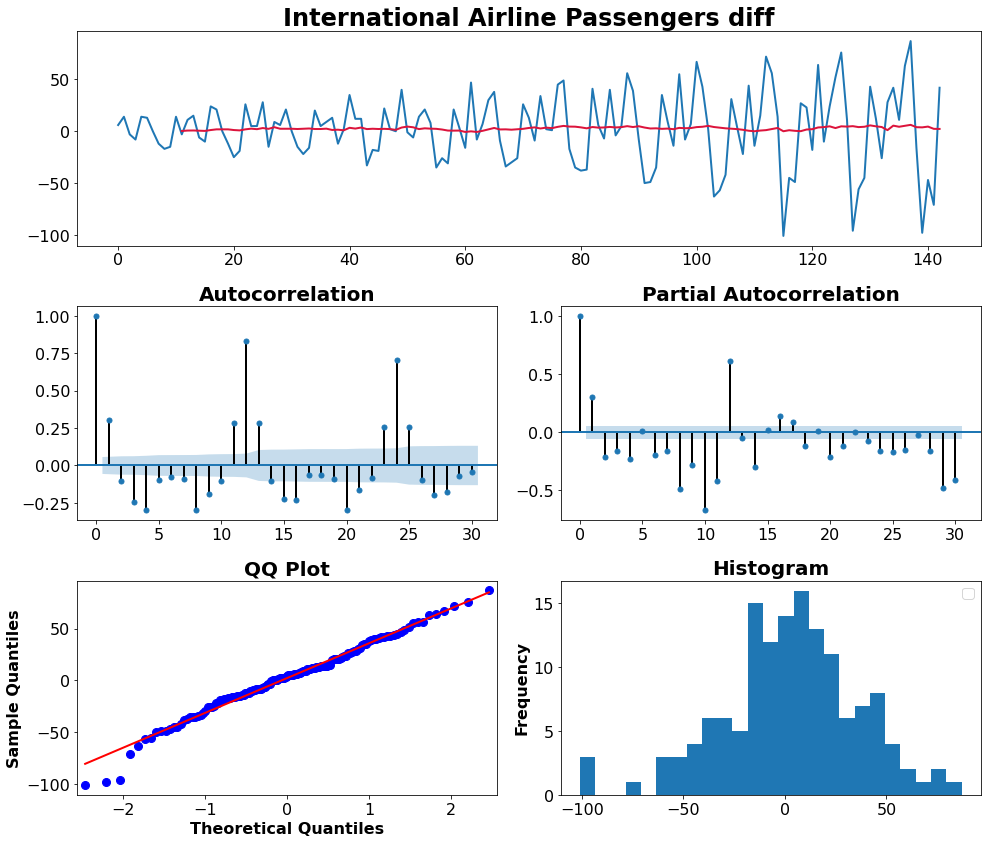

Results of Dickey-Fuller test:
test statistic           -2.829267
p-value                   0.054213
# of lags                12.000000
# of observations       130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [ ]:
ts_diagnostics(y_diff, lags=30, title='International Airline Passengers diff')

<ul>
<li>ADF test statistic이 좋아졌으나 ACF, PACF를 보았을 때 약간의 serial corrrelation이 남아있음.
</li>
<li>평균은 거의 0에 근접하나 시간에 따른 분산이 커짐. 아직 stationary라 판단할 수 없음.</li>
</ul>

## 4.2 Log transformation

$$
y^{log}_t = log(y_t)
$$

In [ ]:
y_log = np.log(y)

No handles with labels found to put in legend.


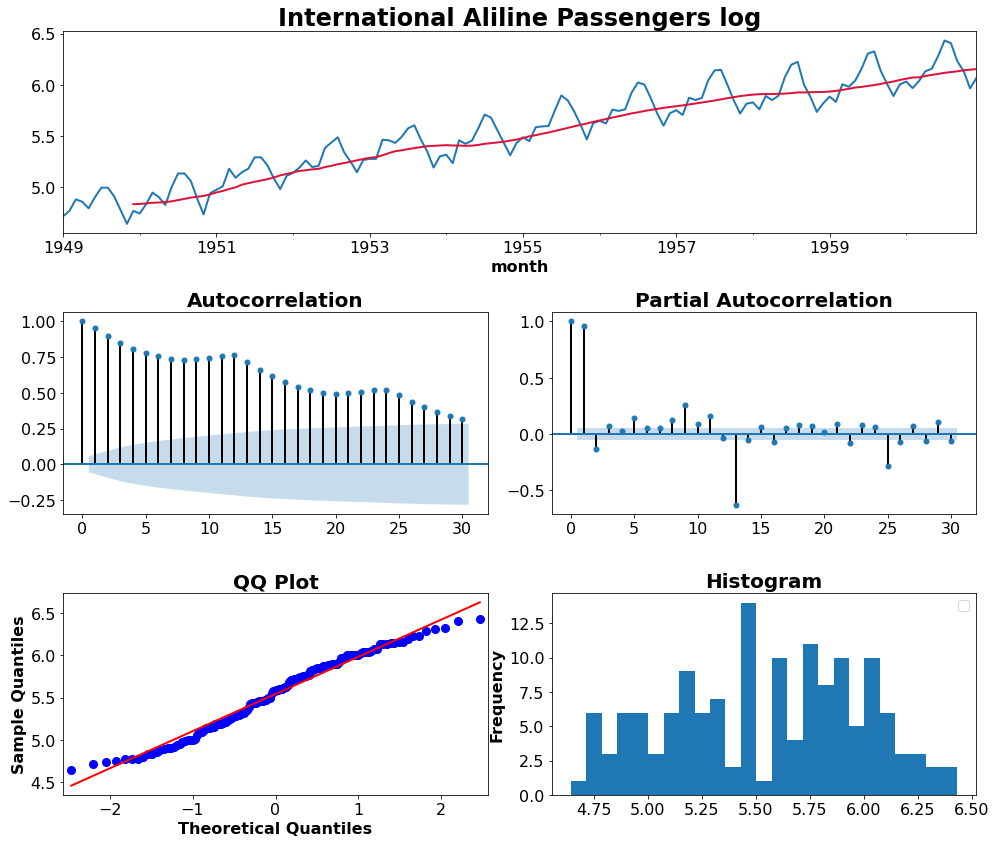

Results of Dickey-Fuller test:
test statistic           -1.717017
p-value                   0.422367
# of lags                13.000000
# of observations       130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [ ]:
ts_diagnostics(y_log, lags=30, title='International Aliline Passengers log')

<ul>
<li>로그를 취하여 전체적인 분산이 줄어든 것을 확인.</li>
<li>Test statistic이 critical value보다 높으므로 non-stationary</li>
<li>차분을 하지 않았으므로 평균이 선형 증가</li>
</ul>

## 4.3 Log transformed first order difference

$$
y'_t = log(y_t) - log(y_{t-1})
$$

In [ ]:
y_log_diff = np.log(y).diff().dropna()

No handles with labels found to put in legend.


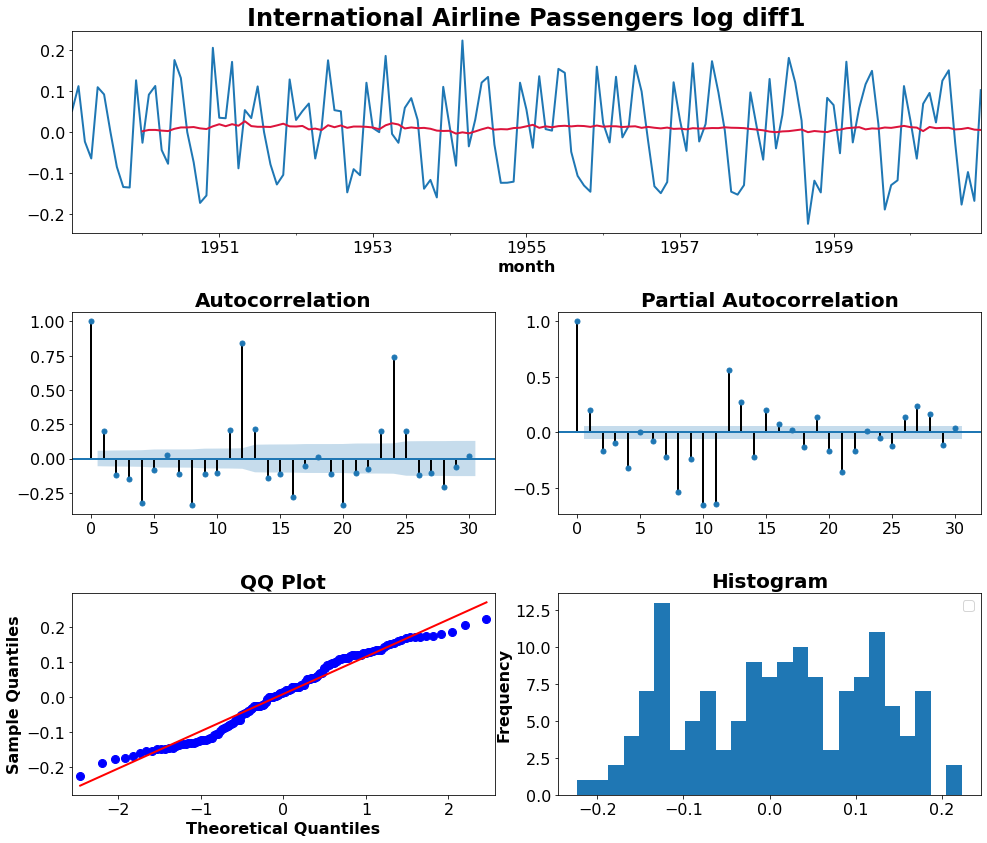

Results of Dickey-Fuller test:
test statistic           -2.717131
p-value                   0.071121
# of lags                14.000000
# of observations       128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [ ]:
ts_diagnostics(y_log_diff, lags=30, title='International Airline Passengers log diff1')

<ul>
<li>Trend 패턴이 제거되고 평균이 0임</li>
<li>Test statistic이 critical value에 비해 높으므로 statinary하다고 단정짓기 어려움.</li>
</ul>


## 4.4 Log transformed second order difference

시계열이 아직 stationary 하지 않으므로 한 번 더 차분해줌

In [ ]:
y_log_diff2 = np.log(y).diff(1).diff(12).dropna()

No handles with labels found to put in legend.


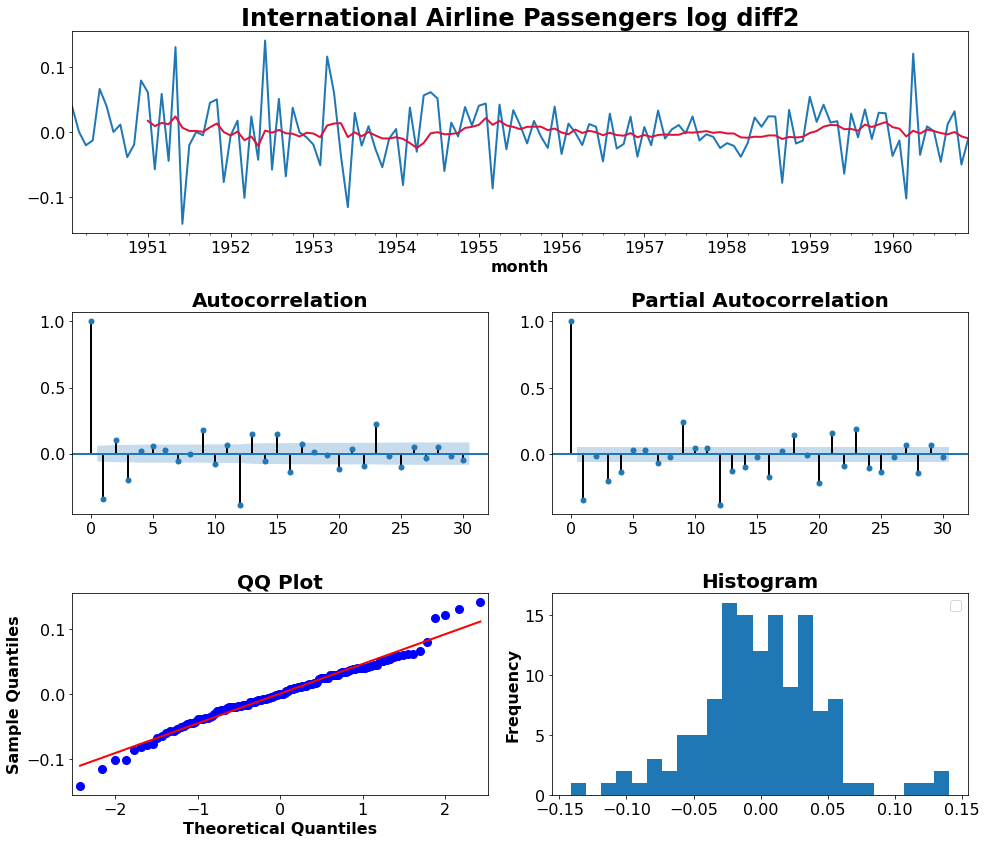

Results of Dickey-Fuller test:
test statistic           -4.443325
p-value                   0.000249
# of lags                12.000000
# of observations       118.000000
Critical Value (1%)      -3.487022
Critical Value (5%)      -2.886363
Critical Value (10%)     -2.580009
dtype: float64


In [ ]:
ts_diagnostics(y_log_diff2, lags=30, title='International Airline Passengers log diff2')

ACF와 PACF가 confidence interval 바깥에 있는 spike들이 있으므로 어느 정도 패턴이 남아 있음을 확인할 수 있음. ADF 테스트를 통해 어느 정도 stationary 하다고 가정할 수 있음.
